![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# Model-Agnostic Interpretation with SHAP for Image Analysis

In this Notebook, we will demonstrate how to use the SHapley Additive exPlanations (SHAP) method and interpret its results for image classification models.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. To start working on the notebook, click on the following button. This will open this page in the Colab environment, and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/Juelich-2024/xai-for-cnn/Tutorial_SHAP_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Now that you opened the notebook in Google Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive, and you can navigate it through the lefthand panel in Colab. You might also have received an email that informs you about the access on your Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
!git clone --branch Juelich-2024 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials/xai-for-cnn
%pip install shap==0.41

### Imports

Let's start with importing all required Python packages.

In [1]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import utils

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [ ]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

--------

## Data and Model Loading: The MNIST Dataset

Let's use the MNIST dataset to see how SHAP can be used to explain image classification models. The MNIST dataset contains images of handwritten digits with numbers from 0 to 9. 

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_digits.png?raw=true" width="700" /></center>

<font size=1> Source:
[Link](https://towardsdatascience.com/part-5-training-the-network-to-read-handwritten-digits-c2288f1a2de3)

Let's train a simple 2D Convolutional Neural Network (CNN) for a small number of epochs on our training images.

*Note: this is a very basic model to showcase how SHAP works for image classification. To know more about it, check out the model in the data_and_model folder and other functions we used in the utils.*

In [2]:
# train model 
model, test_loader = utils.get_trained_model(nb_of_epochs=5)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309319
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.257481
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.828923
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.905061
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.795729

Test set: Average loss: 0.0051, Accuracy: 8783/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.667661
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.763977
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.535311
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.621729
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.405337

Test set: Average loss: 0.0028, Accuracy: 9290/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.465148
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.566859
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.347913
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.373605
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.474412

Test set: Average loss: 0.0020, Accuracy: 9464/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.340611
Train Epoch: 4 [12800/60000 (21%)]	Lo

Great, now you have a simple trained CNN model with a high accuracy of ~96%!  

## Now, what does my model think is important in the data?

We prepared a small [Introduction to SHAP](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/shap.html) for you, to help you understand how this method works.

*Note: we provide all references [here](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/shap.html#references).*

Now, let's use SHAP to get insights into the image classification model. The `shap.Explainer()` class estimates the Shapley values to explain any machine learning model. Within this class, multiple explainers can be used to explain which features are important in an image for classification. Some of them are:
* [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html)
* [PartitionExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.PartitionExplainer.html)
* [GradientExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.GradientExplainer.html#shap.GradientExplainer)

All of the above use specific methods to approximate Shapley values for deep learning models. In this course, we will focus on the implementation of `shap.GradientExplainer()`,  which calculates Shapley values for CNN models in a fast and model-specific way. You can read more about each explainer in the [SHAP API](https://shap.readthedocs.io/en/latest/api.html#explainers).

**GradientExplainer**

Many models, including several neural networks, are gradient-based. Gradient-based explanation methods leverage the ability to compute gradients of the loss function with respect to the model input features to explain model predictions. By analyzing how the model's output changes in response to variations in the input features, these methods provide insights into the factors driving model decisions: if a pixel is relevant, a small change in it has big impact on the output, therefore the gradient is high.

The gradients can be used to approximate the Shapley values and GradientExplainer allows to do this estimetion in a fast and efficient way. There’s a connection between the gradient estimator used in GradientExplainer and an explainability method called **Integrated Gradients** ([Sundararajan et al. 2017](https://doi.org/10.48550/arXiv.1703.01365)).
Integrated Gradients is a feature attribution gradient-based method that computes the integral of the gradients on a path which is a straight line from a baseline (e.g. black image) to the input.
The difference between Integrated Gradients and SHAP values is that Integrated Gradients use a single reference point, while Shapley values utilize a background data set. 
We will not go into the details here, but rather focus on interpreting the results. To know more about how the SHAP class shap.GradientExplainer() approximates the Shapley values, we recommend reading the SHAP documentation and the "Interpreting Machine Learning Models With SHAP" book ([Molnar 2022](https://leanpub.com/shap)). 


### Step 1 - Create a baseline

We need to select a part of our data set to create a baseline, i.e., the background dataset to use for integrating our features.

In [3]:
batch = next(iter(test_loader))
images, labels = batch

baseline = images[:100]
img_to_explain = images[100:103]

### Step 2 - Instantiate the class
We decided to focus on GradientExplainer, which is implemented in the `shap.GradientExplainer()`.  
The first argument is the model (or a tuple containing the model and the layer that should be explained, which will return Shapley values for the input of the layer argument - see [example](https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/gradient_explainer/Explain%20an%20Intermediate%20Layer%20of%20VGG16%20on%20ImageNet%20%28PyTorch%29.html)). The second argument is the baseline built with the background dataset.

In [4]:
# explain model prediction
explainer = shap.GradientExplainer(model, baseline)

### Step 3 - Compute SHAP values on a custom image

In the `shap_values()` method we pass as a tensor the image(s) we want to explain.

In [5]:
shap_values = explainer.shap_values(img_to_explain)
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values] # unroll the axes

### Step 4 - Plot results

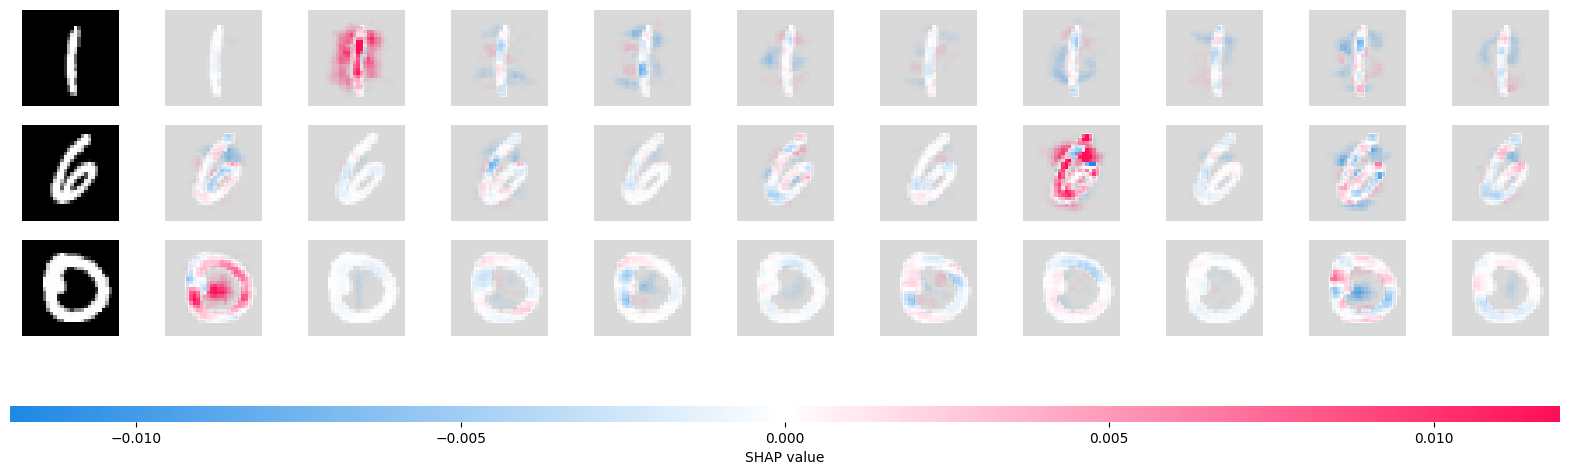

In [6]:
img_to_plot = np.array(img_to_explain).swapaxes(-1,1).swapaxes(1, 2)
shap.image_plot(shap_values, img_to_plot)

SHAP uses colors to explain the pixel attribution:
- Red pixels increase the probability of a class being predicted
- Blue pixels decrease the probability of a class being predicted

In the images above, the input images are shown on the left column and the other columns show the SHAP value for the classes from 1 to 9, with the original image nearly transparent grayscale backings behind each of the explanations. The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset) and the current model output.

<font color='green'>

#### Question 1: Can you explain from the plot what the Shapley values tell us?

<font color='grey'>

#### Your Answer:
One plausible explanation is that, in the case of the digit zero, the empty space in the center of the image significantly influences the prediction of the correct class. Conversely, for the eighth class, those same pixels appear blue because that vacant space would have been occupied.

Another valid interpretation is that, for the digit six, the absence of a connection in the top-right part of the number plays a pivotal role in the prediction.
    
<font color='green'>

#### Question 2: Why is SHAP  considered a contrastive method?

Hint: think about the role of the baseline, can you think about other ways to create a baseline for images (image with no features)?

<font color='grey'>

#### Your Answer:
The key lies in the role of the baseline or reference dataset. In explainability methods like SHAP, each time we select a baseline or reference dataset, it effectively establishes a basis for contrast. It compares the features of the input data, such as an image with specific features, against those of a reference dataset, typically an image lacking those features. This contrastive approach enables the quantification of how much each feature contributes to the model's prediction in relation to the chosen baseline. This process significantly aids in comprehending the underlying behavior of the model. It's worth noting that attributions in SHAP are relative values, representing contributions compared to the selected baseline.  Therefore, this method is that the attributions are not absolute values, but they are the contributions compared to a baseline.

Another conceptual limitation is the choice of a baseline that might change the explanation we get [Sturmfels et al., 2020](https://distill.pub/2020/attribution-baselines/).
    
<font color='green'>

#### Question 3: What do you think are the strengths and weaknesses of SHAP on image classification?

<font color='grey'>

#### Your Answer: 
- Model-agnostic: SHAP can be applied to any machine learning model, not limited to CNNs, making it versatile for different architectures.
- Global and local interpretability: SHAP provides both global and local interpretability, allowing you to understand feature importance for individual predictions and the model's overall behavior.
- Quantitative explanations: It assigns attribution values to each feature (e.g., pixels in an image), providing a quantitative measure of their impact on the model's decision.
- Consistency: SHAP values adhere to Shapley values, which have a solid theoretical foundation in cooperative game theory.

Cons:
- Computationally intensive: Computing SHAP values can be resource-intensive, especially for complex models and large datasets.
- Complexity: Understanding and implementing SHAP values may require a deeper understanding of the SHAP framework and concepts like cooperative game theory.
- Some approximation is required: For deep learning models, exact SHAP values are often infeasible to compute, so approximations are used, potentially leading to less precise explanations.
- The choice of baseline images can significantly affect SHAP results (or any method that relies on baselines) - [Sturmfels et al., 2020](https://distill.pub/2020/attribution-baselines/)
    